# Fire or Not?  
<hr style="border:2px solid magenta"> 

**Description** 
* Wildfires are very unpredictable and can occur randomly. Using sattelite images, we can in real time detect a wildfire and warn the proper authorities to mitigate the outgoing damage from wildfires. 

**Objective**
* Create a model that can detect if there is a wildfire in the image with a high f1 score as this is a measure that combines recall and precision of the model. We would want authorities to respond to a real wildfire and false alarm rather than not be alerted that there is a wildfire. It is better to be safe than sorry.  

**Methodology**
* Using a Convolutional Neural Network for wildfire detection. The architecture was designed usign Keras API and was implemented using Python, Tensorflow.  

**Data**
* The dataset was provided by Kaggle: [Wildfire Prediction Dataset (Satellite Images)](https://www.kaggle.com/datasets/abdelghaniaaba/wildfire-prediction-dataset/data). It has been divided into three directories: test, train, and validation. The file name are the coordinates of the wildfire location.

### Imports
<hr style="border:2px solid magenta">  

Grabbing the important imports needed

In [14]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import backend

from sklearn.metrics import classification_report
from tensorflow.keras.metrics import FalseNegatives, FalsePositives, TrueNegatives, TruePositives

In [15]:
from src.extract_to_df import extract_to_df
from src.visualizations import plot_cm, plot_graph
from src.metric_notes import metric_note

In [16]:
#prevent a bug that some images are truncated
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


### Extracting Data  
<hr style="border:2px solid magenta">  

Setting the paths to the data

In [17]:
test = Path('Data/test')
train = Path('Data/train')
valid = Path('Data/valid')

Using a function called extract_to_df that is in the src folder. This function will extract useful information from each file and return a dataframe containing the relative path, latitude and longtitude coordinates, and the class of the image : wildfire or nowildfire. 

In [18]:
train_df = extract_to_df(train, 'Train')
test_df = extract_to_df(test, 'Test')
val_df = extract_to_df(valid,'Valid')

Creating the generators used to extract the images

In [19]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    width_shift_range = 0.2, 
    height_shift_range = 0.2,
    horizontal_flip = True, 
    vertical_flip = True
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255
)

Extracting images. Starting with 32x32 pixels. Might change it to 64x64 or 224x224 which is another image size standard. Pixel can be changed for the images. It helps with renaming the files and such later on. 

In [20]:
pixel = 64
size = f'{pixel}x{pixel}'

In [21]:
train_images = train_generator.flow_from_dataframe(dataframe=train_df,
                                                 x_col = 'Path',
                                                 y_col = 'Label',                           
                                                 target_size = (pixel,pixel),
                                                 class_mode = 'binary',
                                                 color_mode = 'rgb',
                                                 shuffle = True,
                                                 seed = 42,
                                                 batch_size = 128)

valid_images = train_generator.flow_from_dataframe(dataframe=val_df,
                                                 x_col = 'Path',
                                                 y_col = 'Label',                           
                                                 target_size=(pixel,pixel),
                                                 class_mode = 'binary',
                                                 color_mode = 'rgb',
                                                 shuffle = True,
                                                 seed = 42,
                                                 batch_size = 64)

test_images = test_generator.flow_from_dataframe(dataframe=test_df,
                                                 x_col='Path',
                                                 y_col='Label',
                                                 target_size=(pixel,pixel),
                                                 class_mode='binary',
                                                 color_mode='rgb',
                                                 shuffle=True,
                                                 seed=42,
                                                 batch_size=128)


Found 30250 validated image filenames belonging to 2 classes.
Found 6300 validated image filenames belonging to 2 classes.
Found 6300 validated image filenames belonging to 2 classes.


There is a lot of images already. Roughly 42850 images.

In [22]:
metrics = metric_note(train_images, test_images, valid_images)

### Modeling TIME  
<hr style="border:2px solid magenta">  

Let's do a simple CNN with 1-Convolutional Layer

In [24]:
cnn1 = Sequential()
cnn1.add(Conv2D(filters=32,
                kernel_size=(3, 3),
                activation='relu',
                input_shape=(pixel,pixel, 3)))
cnn1.add(MaxPooling2D(pool_size=(2,2)))

cnn1.add(Flatten())

cnn1.add(Dense(128, activation='relu'))
cnn1.add(Dense(1, activation='sigmoid'))

cnn1.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy', TruePositives(thresholds= .5), TrueNegatives(thresholds= .5), FalsePositives(thresholds= .5), FalseNegatives(thresholds= .5)])


Adding an early stopping to prevent overfitting and save computational resources and time. 

In [25]:
early_stop = tf.keras.callbacks.EarlyStopping(
            monitor='loss',
            patience=4,
            restore_best_weights=True
        )

Fit the train_images into this one deep cnn with a batch size of 64, epochs of 50, validation data with valid_iamges. Using the early stopping for the reason mentioned above and using workers of 6 (Which I believe is similar to n_jobs in sklearn)

In [26]:
train_images

In [27]:
results1 = cnn1.fit(train_images,
                    batch_size = 64, 
                    epochs = 50,
                    validation_data = valid_images,
                    callbacks = [early_stop],
                    workers = 6)

Epoch 1/50
237/237 [==============================] - 23s 92ms/step - loss: 0.3584 - accuracy: 0.8401 - true_positives_1: 12996.0000 - true_negatives_1: 12418.0000 - false_positives_1: 2082.0000 - false_negatives_1: 2754.0000 - val_loss: 0.2200 - val_accuracy: 0.9137 - val_true_positives_1: 3261.0000 - val_true_negatives_1: 2495.0000 - val_false_positives_1: 325.0000 - val_false_negatives_1: 219.0000
Epoch 2/50
237/237 [==============================] - 21s 88ms/step - loss: 0.2340 - accuracy: 0.9093 - true_positives_1: 14720.0000 - true_negatives_1: 12787.0000 - false_positives_1: 1713.0000 - false_negatives_1: 1030.0000 - val_loss: 0.2273 - val_accuracy: 0.9114 - val_true_positives_1: 3136.0000 - val_true_negatives_1: 2606.0000 - val_false_positives_1: 214.0000 - val_false_negatives_1: 344.0000
Epoch 3/50
237/237 [==============================] - 21s 89ms/step - loss: 0.2208 - accuracy: 0.9156 - true_positives_1: 14752.0000 - true_negatives_1: 12945.0000 - false_positives_1: 1555.00

Already at 95% accurate and 0.1220 log loss. This is a strong model already.

In [28]:
metrics.evaluate(cnn1, 'CNN 1', size)

99/99 [==============================] - 13s 128ms/step - loss: 0.1627 - accuracy: 0.9379 - true_positives_1: 3180.0000 - true_negatives_1: 2729.0000 - false_positives_1: 91.0000 - false_negatives_1: 300.0000


In [29]:
metrics.printout

,Model,Size,train log_loss,train accuracy,train TP,train TN,train FP,train FN,test log_loss,test accuracy,test TP,test TN,test FP,test FN,val log_loss,val accuracy,val TP,val TN,val FP,val FN
0,CNN 1,64x64,0.156865,0.936893,14495.0,13846.0,654.0,1255.0,0.160503,0.94127,3161.0,2769.0,51.0,319.0,0.162682,0.937936,3180.0,2729.0,91.0,300.0


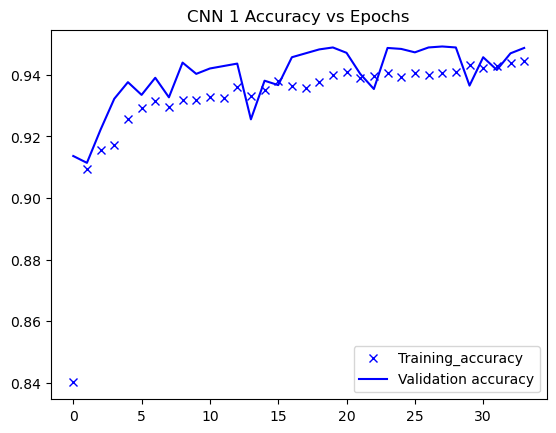

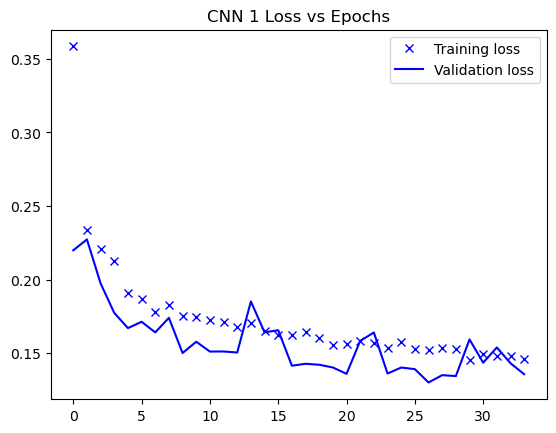

<Figure size 640x480 with 0 Axes>

In [30]:
plot_graph(results1, size, 'CNN 1')

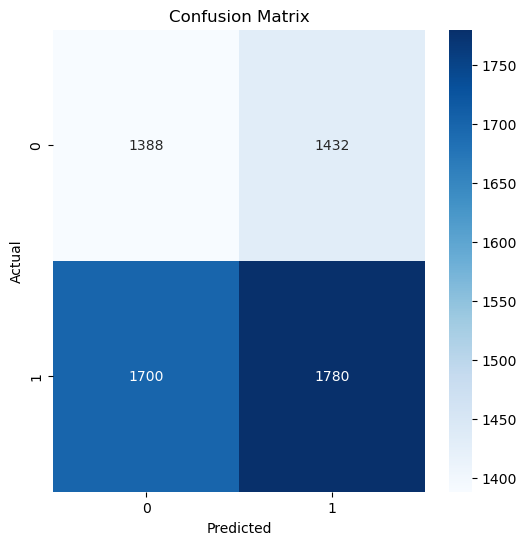

In [31]:
cnn1_predictions = plot_cm(cnn1, 'CNN 1', test_images, size)

In [32]:
cnn1_predictions

array([[0],
       [1],
       [0],
       ...,
       [0],
       [1],
       [1]])

In [33]:
test_images.labels

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [34]:
print(classification_report(y_true = test_images.labels, y_pred = cnn1_predictions))

              precision    recall  f1-score   support

           0       0.45      0.49      0.47      2820
           1       0.55      0.51      0.53      3480

    accuracy                           0.50      6300
   macro avg       0.50      0.50      0.50      6300
weighted avg       0.51      0.50      0.50      6300



In [35]:
backend.clear_session()


<hr style="border:2px solid magenta">  

Let's increase the complexity by making 4 deep. I am going to add some dropout and batchnormalization to help prevent overfitting

In [36]:
cnn4 = Sequential()

cnn4.add(Conv2D(filters=32,
                kernel_size=3,
                activation='relu',
                input_shape=(pixel,pixel, 3)))
cnn4.add(MaxPooling2D(pool_size=2))
cnn4.add(BatchNormalization())
cnn4.add(Dropout(0.2))

cnn4.add(Conv2D(filters=32,
                kernel_size=3,
                activation='relu'))
cnn4.add(MaxPooling2D(pool_size=2))
cnn4.add(BatchNormalization())
cnn4.add(Dropout(0.2))

cnn4.add(Conv2D(filters=64,
                kernel_size=3,
                activation='relu'))
cnn4.add(MaxPooling2D(pool_size=2))
cnn4.add(BatchNormalization())
cnn4.add(Dropout(0.2))

cnn4.add(Conv2D(filters=128,
                kernel_size=3,
                activation='relu'))
cnn4.add(MaxPooling2D(pool_size=2))
cnn4.add(BatchNormalization())
cnn4.add(Dropout(0.2))

cnn4.add(Flatten())

cnn4.add(Dense(128, activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(Dropout(0.2))

cnn4.add(Dense(1, activation='sigmoid'))

cnn4.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy', TruePositives(thresholds= .5), TrueNegatives(thresholds= .5), FalsePositives(thresholds= .5), FalseNegatives(thresholds= .5)])


In [37]:
cnn4.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 31, 31, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 32)        1

In [38]:
results4 = cnn4.fit(train_images,
                    batch_size = 64, 
                    epochs = 50,
                    validation_data = valid_images,
                    callbacks = [early_stop],
                    workers = 6)

Epoch 1/50
237/237 [==============================] - 23s 91ms/step - loss: 0.2328 - accuracy: 0.9081 - true_positives: 14561.0000 - true_negatives: 12909.0000 - false_positives: 1591.0000 - false_negatives: 1189.0000 - val_loss: 1.4024 - val_accuracy: 0.5524 - val_true_positives: 3480.0000 - val_true_negatives: 0.0000e+00 - val_false_positives: 2820.0000 - val_false_negatives: 0.0000e+00
Epoch 2/50
237/237 [==============================] - 22s 91ms/step - loss: 0.1888 - accuracy: 0.9247 - true_positives: 14751.0000 - true_negatives: 13220.0000 - false_positives: 1280.0000 - false_negatives: 999.0000 - val_loss: 0.7514 - val_accuracy: 0.6990 - val_true_positives: 3478.0000 - val_true_negatives: 926.0000 - val_false_positives: 1894.0000 - val_false_negatives: 2.0000
Epoch 3/50
237/237 [==============================] - 22s 91ms/step - loss: 0.1713 - accuracy: 0.9326 - true_positives: 14863.0000 - true_negatives: 13349.0000 - false_positives: 1151.0000 - false_negatives: 887.0000 - val_

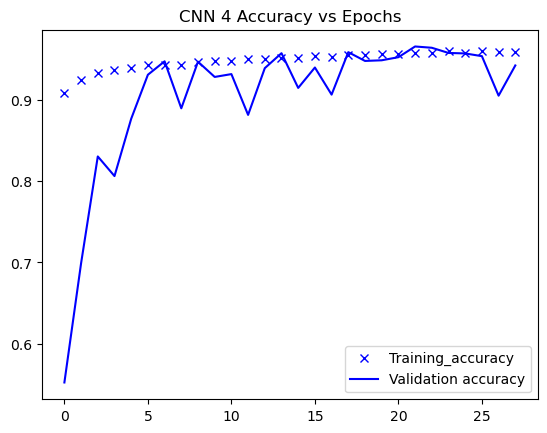

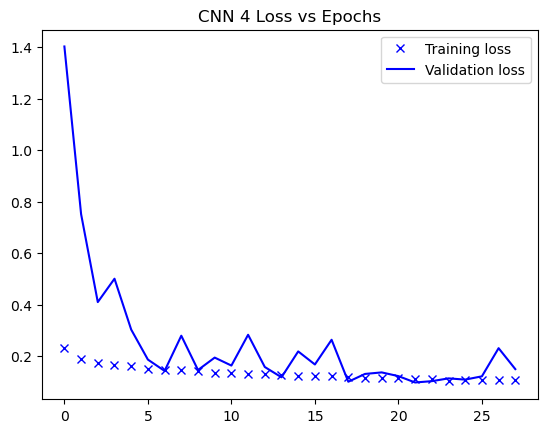

<Figure size 640x480 with 0 Axes>

In [39]:
plot_graph(results4, size, 'CNN 4')

In [40]:
metrics.evaluate(cnn4, 'CNN 4', size)


99/99 [==============================] - 13s 128ms/step - loss: 0.1210 - accuracy: 0.9541 - true_positives: 3382.0000 - true_negatives: 2629.0000 - false_positives: 191.0000 - false_negatives: 98.0000


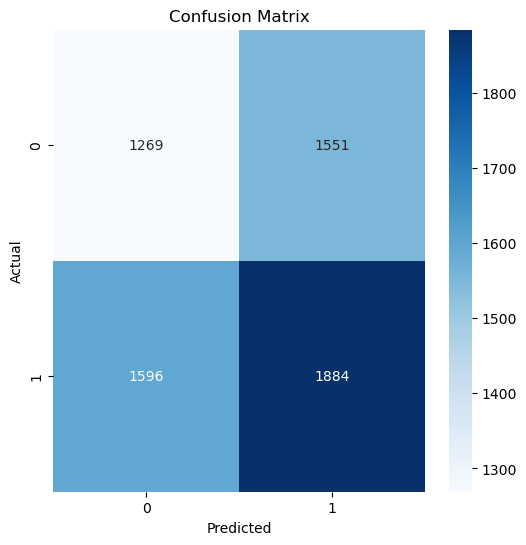

In [41]:
cnn4_predictions = plot_cm(cnn4, 'CNN 4', test_images, size)

In [42]:
print(classification_report(y_true = test_images.labels, y_pred = cnn4_predictions))

              precision    recall  f1-score   support

           0       0.44      0.45      0.45      2820
           1       0.55      0.54      0.54      3480

    accuracy                           0.50      6300
   macro avg       0.50      0.50      0.50      6300
weighted avg       0.50      0.50      0.50      6300



In [43]:
metrics.printout

,Model,Size,train log_loss,train accuracy,train TP,train TN,train FP,train FN,test log_loss,test accuracy,test TP,test TN,test FP,test FN,val log_loss,val accuracy,val TP,val TN,val FP,val FN
0,CNN 1,64x64,0.156865,0.936893,14495.0,13846.0,654.0,1255.0,0.160503,0.941270,3161.0,2769.0,51.0,319.0,0.162682,0.937936,3180.0,2729.0,91.0,300.0
1,CNN 4,64x64,0.128365,0.952397,15438.0,13372.0,1128.0,312.0,0.100879,0.962698,3340.0,2725.0,95.0,140.0,0.121046,0.954127,3382.0,2629.0,191.0,98.0


In [44]:
np.sum(cnn4_predictions == 1)

3435

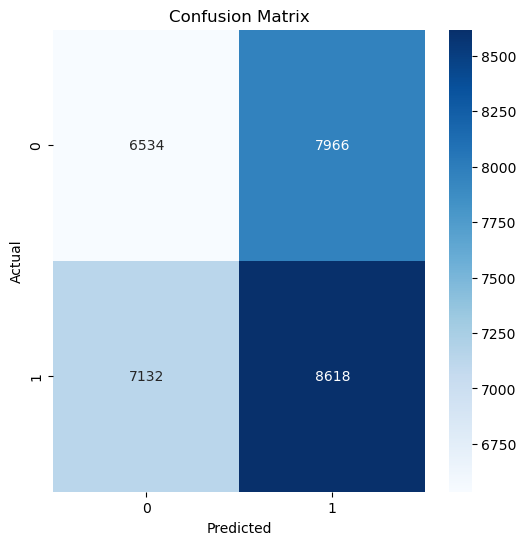

In [45]:
cnn4_check = plot_cm(cnn4, 'CNN 4', train_images, size)

In [46]:
backend.clear_session()

<hr style="border:2px solid magenta">  

In [47]:
metrics.printout.to_csv(f'Dataframes/{size}CNN.csv')